In [1]:
import sys
from unstructured.partition.pdf import partition_pdf

/Users/pablo.vizan/Projects/documesh/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:

pdf_folder_path = "."
pdf_file_name = "google-10k-sample-14pages.pdf"

# Extract images, tables, and chunk text from a PDF file.
raw_pdf_elements = partition_pdf(
    filename=pdf_file_name,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=pdf_folder_path,
)

In [40]:
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=pdf_file_name,                                # mandatory
    strategy="hi_res",                                     # mandatory to use ``hi_res`` strategy
    extract_images_in_pdf=True,                            # mandatory to set as ``True``
    extract_image_block_types=["Image", "Table"],          # optional
    extract_image_block_to_payload=False,                  # optional
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=pdf_folder_path,
)

In [41]:
from langchain_text_splitters import CharacterTextSplitter

In [42]:
raw_pdf_elements

In [43]:
# Categorize extracted elements from a PDF into tables and texts.
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=10000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [44]:
raw_pdf_elements[0].text

'source: https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf source: https://abc.xyz/assets/9a/bd/838c917c4b4ab21f94e84c3c2c65/goog-10-k-q4-2022.pdf Note: Tables and figures are converted to images for demonstration purposes.\n\nMARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES\n\nAs of October 2, 2015, Alphabet Inc. became the successor issuer of Google Inc. pursuant to Rule 12g-3(a) under the Exchange Act. Our Class A common stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since August 19, 2004 and under the symbol "GOOGL" since April 3, 2014. Prior to August 19, 2004, there was no public market for our stock. Our Class B common stock is neither listed nor traded. Our Class C capital stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since April 3, 2014.\n\nHolders of Record\n\nAs of December 31, 2021, there were approximately 4,907 and 1,733 stock

In [45]:
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_google_vertexai import (
    ChatVertexAI,
    VectorSearchVectorStore,
    VertexAI,
    VertexAIEmbeddings,
)
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser



MODEL_NAME = "gemini-2.0-flash"
GEMINI_OUTPUT_TOKEN_LIMIT = 8192

EMBEDDING_MODEL_NAME = "text-embedding-005"
EMBEDDING_TOKEN_LIMIT = 2048

TOKEN_LIMIT = min(GEMINI_OUTPUT_TOKEN_LIMIT, EMBEDDING_TOKEN_LIMIT)

In [46]:
# Generate summaries of text elements


def generate_text_summaries(
    texts: list[str], tables: list[str], summarize_texts: bool = False
) -> tuple[list, list]:
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = VertexAI(
        temperature=0, model_name=MODEL_NAME, max_output_tokens=TOKEN_LIMIT
    ).with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts:
        if summarize_texts:
            text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
        else:
            text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)
     

In [23]:
print(texts)

['source: https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf source: https://abc.xyz/assets/9a/bd/838c917c4b4ab21f94e84c3c2c65/goog-10-k-q4-2022.pdf Note: Tables and figures are converted to images for demonstration purposes.\n\nMARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES\n\nAs of October 2, 2015, Alphabet Inc. became the successor issuer of Google Inc. pursuant to Rule 12g-3(a) under the Exchange Act. Our Class A common stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since August 19, 2004 and under the symbol "GOOGL" since April 3, 2014. Prior to August 19, 2004, there was no public market for our stock. Our Class B common stock is neither listed nor traded. Our Class C capital stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since April 3, 2014.\n\nHolders of Record\n\nAs of December 31, 2021, there were approximately 4,907 and 1,733 stoc

In [50]:
import os
import base64

def encode_image(image_path: str) -> str:
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(model: ChatVertexAI, base64_image: str, prompt: str) -> str:
    """Make image summary"""
    msg = model.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path: str) -> tuple[list[str], list[str]]:
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval.
    If it's a table, extract all elements of the table.
    If it's a graph, explain the findings in the graph.
    Do not include any numbers that are not mentioned in the image.
    """

    model = ChatVertexAI(model_name=MODEL_NAME, max_output_tokens=TOKEN_LIMIT)

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            base64_image = encode_image(os.path.join(path, img_file))
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(model, base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries("figures/")

In [52]:
image_summaries

['This is a financial table showing basic and diluted net income per share for the year ended December 31, 2019, for Class A, Class B, and Class C shares. Allocation of undistributed earnings, Number of shares used in per share computation, Reallocation of undistributed earnings as a result of conversion of Class B to Class A shares outstanding, Restricted stock units and other contingently issuable shares are also mentioned.',
 'This table summarizes the activities for unvested Alphabet RSUs for the year ended December 31, 2021. The number of shares and weighted-average grant-date fair value are provided. The table includes Unvested as of December 31, 2020, Granted, Vested, Forfeited/canceled and Unvested as of December 31, 2021. The number of shares for Unvested as of December 31, 2020 is 19,288,793. The number of shares Granted is 10,582,700. The number of shares Vested is (11,209,486). The number of shares Forfeited/canceled is (1,767,294). The number of shares Unvested as of Decem

In [53]:
from google.cloud import aiplatform
# Environment variables and configuration
PROJECT_ID = "hacker2025-team-5-dev"
BUCKET_NAME = "example_bucket_airbus"  # Replace with your GCS bucket name
LOCATION = "europe-west4"
GCS_BUCKET_URI = f"gs://{BUCKET_NAME}"

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=GCS_BUCKET_URI)

In [54]:

# https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text-embeddings
DIMENSIONS = 768  # Dimensions output from text-embedding-005

index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name="mm_rag_langchain_index",
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description="Multimodal RAG LangChain Index",
    index_update_method="STREAM_UPDATE",
)
     

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/246245275285/locations/europe-west4/indexes/673235367733755904/operations/7558779739561787392
MatchingEngineIndex created. Resource name: projects/246245275285/locations/europe-west4/indexes/673235367733755904
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/246245275285/locations/europe-west4/indexes/673235367733755904')


In [55]:

DEPLOYED_INDEX_ID = "mm_rag_langchain_index_endpoint"

index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DEPLOYED_INDEX_ID,
    description="Multimodal RAG LangChain Index Endpoint",
    public_endpoint_enabled=True,
)

Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256/operations/1366330251927355392
MatchingEngineIndexEndpoint created. Resource name: projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256')


In [56]:

index_endpoint = index_endpoint.deploy_index(
    index=index, deployed_index_id="mm_rag_langchain_deployed_index"
)
index_endpoint.deployed_indexes

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256/operations/2478156409934446592
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256


[id: "mm_rag_langchain_deployed_index"
index: "projects/246245275285/locations/europe-west4/indexes/673235367733755904"
create_time {
  seconds: 1750422958
  nanos: 177242000
}
index_sync_time {
  seconds: 1750424474
  nanos: 403105000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

In [57]:


# The vectorstore to use to index the summaries
vectorstore = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=LOCATION,
    gcs_bucket_name=BUCKET_NAME,
    index_id=index.name,
    endpoint_id=index_endpoint.name,
    embedding=VertexAIEmbeddings(model_name=EMBEDDING_MODEL_NAME),
    stream_update=True,
)

In [58]:

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

docstore = InMemoryStore()

id_key = "doc_id"
# Create the multi-vector retriever
retriever_multi_vector_img = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

In [59]:

from langchain_core.documents import Document
import uuid

# Raw Document Contents
doc_contents = texts + tables + img_base64_list

doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries + table_summaries + image_summaries)
]

retriever_multi_vector_img.docstore.mset(list(zip(doc_ids, doc_contents)))

# If using Vertex AI Vector Search, this will take a while to complete.
# You can cancel this cell and continue later.
retriever_multi_vector_img.vectorstore.add_documents(summary_docs)

Upserting datapoints MatchingEngineIndex index: projects/246245275285/locations/europe-west4/indexes/673235367733755904
MatchingEngineIndex index Upserted datapoints. Resource name: projects/246245275285/locations/europe-west4/indexes/673235367733755904


['ee73ecdb-9ab7-40be-b6a6-e69d346861cf',
 '35a1cba5-e3a2-4356-8e3e-634626dfbc99',
 '013fec95-9c08-4fc6-b1be-a15b06073472',
 '912f3b21-1324-428e-bdcc-6f9d05b8d739',
 '51040877-27bb-425e-8c3a-548721d0e601',
 'ab4f0957-6e67-4bac-b075-ff4ba9686a54',
 '781c50b4-d91c-460c-a846-1c5c9af4ca73',
 'a5f24ee0-ba12-4444-ab16-4ccf1ef4349e',
 '48620af8-361d-4a1a-bef4-38c5ca70ade6',
 'a6527404-7cae-4b01-a12d-6f3509e12966',
 '489836c4-4901-4559-9a9a-9a9c1a5869c9',
 '3df51165-1677-4bf0-9e5f-d42b7e1d3d13',
 '8c6e0fbf-40ab-489f-aa2a-52f7e3dd74a9',
 'b8389b20-fb7f-4db8-8a86-f77ddb2382ff']

In [60]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = [
        {
            "type": "text",
            "text": (
                "You are financial analyst tasking with providing investment advice.\n"
                "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
                "Use this information to provide investment advice related to the user's question. \n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    ]

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            messages.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return [HumanMessage(content=messages)]


# Create RAG chain
chain_multimodal_rag = (
    {
        "context": retriever_multi_vector_img | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | ChatVertexAI(
        temperature=0,
        model_name=MODEL_NAME,
        max_output_tokens=TOKEN_LIMIT,
    )  # Multi-modal LLM
    | StrOutputParser()
)
     

In [61]:

query = """
 - What are the critical difference between various graphs for Class A Share?
 - Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.
 - Identify key chart patterns for Google Class A shares.
 - What is cost of revenues, operating expenses and net income for 2020. Do mention the percentage change
 - What was the effect of Covid in the 2020 financial year?
 - What are the total revenues for APAC and USA for 2021?
 - What is deferred income taxes?
 - How do you compute net income per share?
 - What drove percentage change in the consolidated revenue and cost of revenue for the year 2021 and was there any effect of Covid?
 - What is the cause of 41% increase in revenue from 2020 to 2021 and how much is dollar change?
"""


['source: https://abc.xyz/assets/investor/static/pdf/20220202_alphabet_10K.pdf source: https://abc.xyz/assets/9a/bd/838c917c4b4ab21f94e84c3c2c65/goog-10-k-q4-2022.pdf Note: Tables and figures are converted to images for demonstration purposes.\n\nMARKET FOR REGISTRANT’S COMMON EQUITY, RELATED STOCKHOLDER MATTERS AND ISSUER PURCHASES OF EQUITY SECURITIES\n\nAs of October 2, 2015, Alphabet Inc. became the successor issuer of Google Inc. pursuant to Rule 12g-3(a) under the Exchange Act. Our Class A common stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since August 19, 2004 and under the symbol "GOOGL" since April 3, 2014. Prior to August 19, 2004, there was no public market for our stock. Our Class B common stock is neither listed nor traded. Our Class C capital stock has been listed on the Nasdaq Global Select Market under the symbol “GOOG” since April 3, 2014.\n\nHolders of Record\n\nAs of December 31, 2021, there were approximately 4,907 and 1,733 stoc

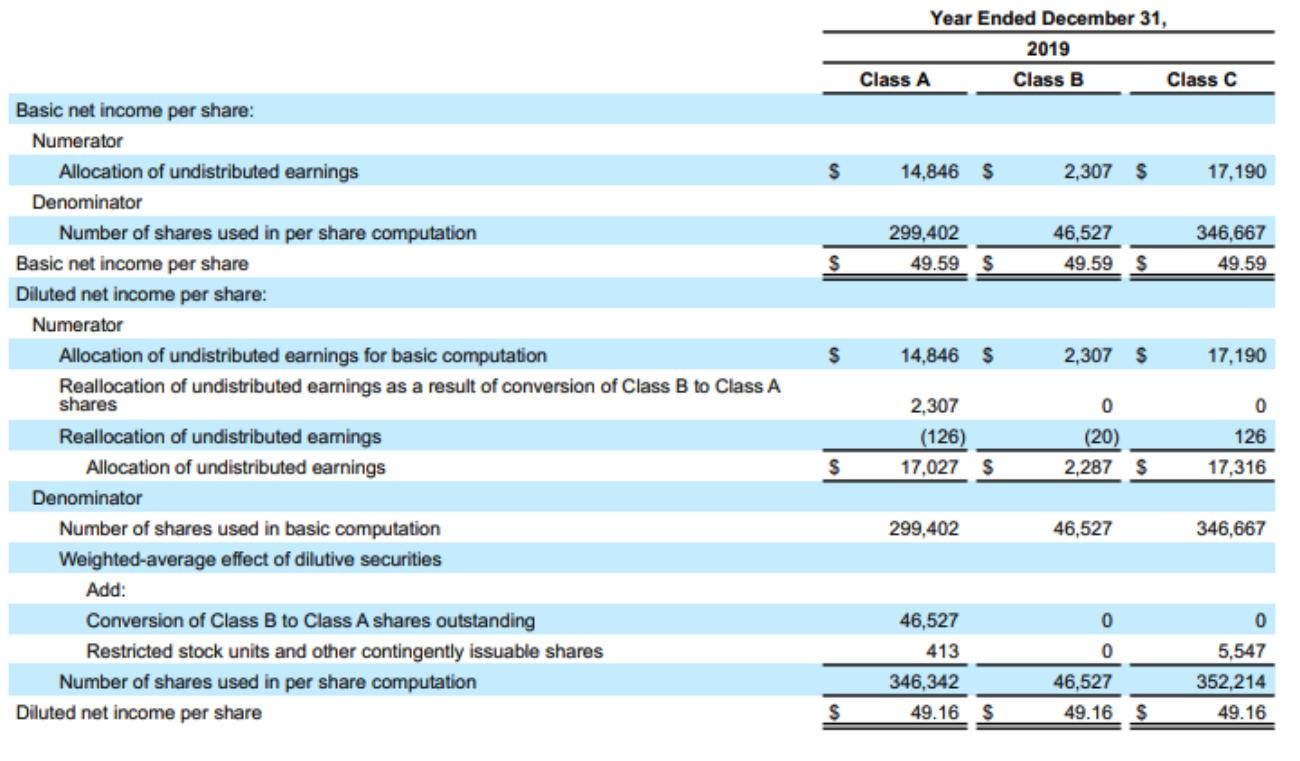

In [63]:
from IPython.display import Image, Markdown, display

# List of source documents
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=10)

source_docs = split_image_text_types(docs)

print(source_docs["texts"])

for i in source_docs["images"]:
    display(Image(base64.b64decode(i)))

In [65]:
result = chain_multimodal_rag.invoke(query)

Markdown(result)

Okay, let's break down the information and address your questions regarding Google's (Alphabet's) Class A shares.

**1. Critical Differences Between Various Graphs for Class A Share**

Unfortunately, you haven't provided any graphs. If you can provide the graphs, I can analyze them and point out the key differences (e.g., different time periods, different metrics being displayed, different scales, etc.).

**2. Which index best matches Class A share performance closely where Google is not already a part? Explain the reasoning.**

To determine which index best matches Class A share performance (excluding Google), you would typically look for indices that have similar sector weightings and market capitalization focus. Since Google is a technology giant, you'd want to avoid tech-heavy indices. A broad market index with a value or blend focus, excluding mega-cap tech companies, might be a reasonable starting point for comparison. Some examples could be:

*   **S&P 400 MidCap Index:** This index represents mid-sized U.S. companies. It would exclude the mega-cap nature of Google, but still provide a view of the overall U.S. market.
*   **Russell 2000:** This index tracks small-cap companies. While Google is obviously not a small-cap, the Russell 2000's performance can sometimes reflect broader economic trends and investor sentiment that might also influence Google's stock.
*   **Dow Jones Industrial Average (DJIA):** The DJIA is a price-weighted index of 30 large, publicly owned companies trading in the United States. It is less tech-heavy than the Nasdaq 100.

To determine the *best* match, you would need to:

1.  **Obtain historical price data** for GOOGL (Class A shares) and the candidate indices.
2.  **Calculate correlation coefficients:** This will quantify how closely the returns of GOOGL move in relation to the returns of each index.
3.  **Consider Beta:** Beta measures a stock's volatility relative to the market. A beta close to 1 suggests similar volatility.
4.  **Visually compare charts:** Plot the performance of GOOGL and the indices over the same time period to see how closely they track each other.

**3. Identify Key Chart Patterns for Google Class A Shares.**

As you have not provided any charts, I am unable to answer this question.

**4. What is cost of revenues, operating expenses and net income for 2020. Do mention the percentage change**

I am unable to answer this question as the information is not available in the provided text.

**5. What was the effect of Covid in the 2020 financial year?**

I am unable to answer this question as the information is not available in the provided text.

**6. What are the total revenues for APAC and USA for 2021?**

I am unable to answer this question as the information is not available in the provided text.

**7. What is deferred income taxes?**

Deferred income taxes arise from temporary differences between the accounting (financial reporting) and tax treatment of certain assets and liabilities. In simpler terms:

*   **Accounting Income vs. Taxable Income:** Sometimes, a company recognizes revenue or expenses in its financial statements in a different period than when they are recognized for tax purposes.
*   **Temporary Differences:** These timing differences create deferred tax assets (future tax benefits) or deferred tax liabilities (future tax obligations).
*   **Deferred Tax Assets:** These arise when a company has paid more taxes than it owes based on its accounting income. This could be due to accelerated depreciation for tax purposes or recognizing expenses earlier for accounting purposes.
*   **Deferred Tax Liabilities:** These arise when a company has paid less taxes than it owes based on its accounting income. This could be due to recognizing revenue earlier for accounting purposes than for tax purposes.

The table you provided shows Alphabet's deferred tax assets and liabilities as of December 31, 2020 and 2021. For example, as of December 31, 2021, Alphabet had net deferred tax *liabilities* of $3,973 million. This means that, in the future, they expect to pay more in taxes than they are currently expensing for accounting purposes due to these temporary differences.

**8. How do you compute net income per share?**

The document provides the following information for the year ended December 31, 2020:

*   **Basic Net Income Per Share:**  (Net Income Available to Common Shareholders) / (Weighted Average Number of Common Shares Outstanding)
    *   For Class A: $17,733 / 299,815 = $59.15
*   **Diluted Net Income Per Share:** This calculation considers the potential dilution that could occur if stock options, warrants, or convertible securities were exercised.
    *   For Class A: $20,285 / 346,084 = $58.61

**9. What drove percentage change in the consolidated revenue and cost of revenue for the year 2021 and was there any effect of Covid?**

I am unable to answer this question as the information is not available in the provided text.

**10. What is the cause of 41% increase in revenue from 2020 to 2021 and how much is dollar change?**

I am unable to answer this question as the information is not available in the provided text.

To provide more specific and helpful advice, please provide the charts you are referring to and the relevant financial statements.


Add 787 document and test

In [68]:
pdf_folder_path = "sample_figures"
pdf_file_name = "787_chapter_2_sample.pdf"

# Extract images, tables, and chunk text from a PDF file.
raw_pdf_elements = partition_pdf(
    filename=pdf_file_name,                                # mandatory
    strategy="hi_res",                                     # mandatory to use ``hi_res`` strategy
    extract_images_in_pdf=True,                            # mandatory to set as ``True``
    extract_image_block_types=["Image", "Table"],          # optional
    extract_image_block_to_payload=False,                  # optional
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    analyzed_image_output_dir_path=pdf_folder_path,
)

In [69]:
# Categorize extracted elements from a PDF into tables and texts.
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=10000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [71]:
# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [85]:
# Image summaries
img_base64_list, image_summaries = generate_img_summaries("figures/")

In [86]:

# Raw Document Contents
doc_contents = texts + tables + img_base64_list

doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries + table_summaries + image_summaries)
]

retriever_multi_vector_img.docstore.mset(list(zip(doc_ids, doc_contents)))

# If using Vertex AI Vector Search, this will take a while to complete.
# You can cancel this cell and continue later.
retriever_multi_vector_img.vectorstore.add_documents(summary_docs)

Upserting datapoints MatchingEngineIndex index: projects/246245275285/locations/europe-west4/indexes/673235367733755904
MatchingEngineIndex index Upserted datapoints. Resource name: projects/246245275285/locations/europe-west4/indexes/673235367733755904


['f05d4435-6678-4b77-ac0f-4bae61ebb1be',
 'd0041afa-eaa4-4b48-936f-1473791bb7c8',
 '491bd75f-7708-486e-aec6-623d4a4be841',
 '61ff4e04-277e-40ce-810a-b5ff9114043f',
 '10c295fc-b9c9-4c64-b24a-a271362dff29',
 '96f7dca3-cc16-46dc-94a0-d32052fb13ec',
 '2ecc8b89-de3f-4c9b-b99f-6b8190dc54ab',
 '8627fcd0-877b-4e71-b0fd-d838e1562e8a',
 'c31716a2-fbef-4bff-b6b4-4fe723aa25a1',
 '1becc86b-f552-4935-9d0f-e7a95b036242',
 'cd2f7d14-99fa-40ad-b72b-2ac4d9246b12',
 '488a047d-cda7-493c-afae-0de72d6968e8',
 '4d593a12-33f8-411d-a933-77a60c6e1493',
 '51cd887d-ef92-4d21-9b23-28759f19a396',
 '8825f612-6ac2-4777-9a93-9cee0ebb809f',
 'ba45fcb3-526e-43fd-b52b-755247742679',
 '5b76670a-5191-4bcf-9998-58a51b18ceea',
 '7d4223e9-a080-4779-b05f-1a15ce19069c']

In [87]:
query = "what is the Max Design Taxi Weight of aircraft 787-8 in Kilograms?"

In [88]:
result = chain_multimodal_rag.invoke(query)

Markdown(result)

Based on the provided document, the Maximum Design Taxi Weight of the Boeing 787-8 is **228,383 kilograms**.


In [91]:
query = "You have technical drawings of the general dimensions of what aircraft models? Please list them."

In [92]:
result = chain_multimodal_rag.invoke(query)

Markdown(result)

Based on the provided documents, I have technical drawings of the general dimensions for the following aircraft models:

*   **787-8**
*   **787-9**
*   **787-10**

In [93]:
query = "What are the general dimensions of the aircraft 787-8 in feet and inches?"

In [94]:
result = chain_multimodal_rag.invoke(query)

Markdown(result)

Based on the provided images, here are the general dimensions of the Boeing 787-8 aircraft in feet and inches:

*   **Wingspan:** 197 feet 3 inches
*   **Length:** 186 feet
*   **Height:** 55 feet 10 inches

In [95]:
query = "Are those the only dimensions available for the aircraft 787-8? If not, what are the other dimensions available?"

result = chain_multimodal_rag.invoke(query)

Markdown(result)

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ServiceUnavailable: 503 GOAWAY received; Error code: 0; Debug Text: session_timed_out.


Based on the provided documents, here are additional dimensions for the Boeing 787-8 aircraft, supplementing the weights, capacities, and volumes you already have:

**From the images:**

*   **Length:** 186 ft (56.7 m)
*   **Wingspan:** 197 ft 3 in (60.12 m)
*   **Height:** 55 ft 10 in (17.02 m)
*   **Tail Height:** 55 ft 10 in (17.02 m)
*   **Fuselage Width:** 19 ft 6 in (5.94 m)
*   **Wheel Track:** 32 ft 2 in (9.80 m)

**From the text:**

*   Maximum Design Taxi Weight (MTW)
*   Maximum Design Takeoff Weight (MTOW)
*   Maximum Design Landing Weight (MLW)
*   Maximum Design Zero Fuel Weight (MZFW)
*   Operating Empty Weight (OEW)
*   Maximum Structural Payload
*   Maximum Seating Capacity
*   Maximum Cargo Volume
*   Usable Fuel

In [97]:
query = "Give me all available information correponding to cabin cross-sections dimensions of the aircraft 787-8. Provide also the name of the section that the drawing corresponds to."

result = chain_multimodal_rag.invoke(query)

Markdown(result)

Here's the information regarding cabin cross-section dimensions for the Boeing 787-8, extracted from the provided text and image:

**Cabin Cross-Section Dimensions (from image of 787-9, but assumed similar to 787-8):**

*   **Cabin Width:** 18 FT 11 IN (5.77 M)
*   **Cabin Height:** 65 FT 0 IN (19.81 M)

**Section Name:**

The drawing corresponds to the "General Dimensions" of the aircraft. Specifically, the image provided seems to be for the 787-9, but the cabin cross-section dimensions are likely similar to the 787-8.

**Additional relevant dimensions from the document (Model 787-8):**

*   **Length:** 186 FT 1 IN (56.72 M)
*   **Height:** 55 FT 6 IN (16.92 M)
*   **Wheel Track:** 34 FT 11 IN (9.73 M)
*   **Wheel Base:** 84 FT 9 IN (25.83 M)

**Disclaimer:** While I've provided the available information, please note that this is based on the provided document and image. For precise engineering specifications, always refer to official Boeing documentation.